This notebook implements the N Queen solution using a Genetic Algorithm, inspired by [Crawford (1992)](https://dl.acm.org/doi/10.1145/130069.130128).

In [6]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell.
# This will ensure your notebook has all the dependencies and works everywhere.
# import sys
# !{sys.executable} -m pip install matplotlib numpy pandas

In [7]:
# import libraries
import sys
sys.path.insert(0,'..')
#
import matplotlib.pyplot as plt
import numpy as np
#
from random import randint as rand
from random import shuffle
from time import time
from utils import create_board, set_board, show_results

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

The aim of N-Queens Problem is to place N queens on an N x N chessboard, in a way so that no queen is in conflict with the others.

### Some terminology

- Chromosome: Genes are joined into a string to form a Chromosome (solution). A chromosome is a set of parameters which define a proposed solution to the problem that the genetic algorithm is trying to solve.
- Fitness value or utility function: a function that determines how good a solution is.
- Crossover: Also called recombination, is a genetic operator used to combine the genetic information of two parents to generate new offspring.
- Mutation: It alters one or more gene values in a chromosome from its initial state

### How does the genetic algorithm solve the n-queen problem?

1. A random chromosome is generated.
2. Fitness value of the chromosome is calculated.
3. If the fitness returns 0, we know that there are no conflicts on the board, therefore, we have our solution. Otherwise continue.
4. Reproduce (crossover) new chromosome from 2 randomly selected best chromosomes.
5. Mutation may take place.
6. New chromosome added to population.
7. Repeat steps 2-6 until a chromosome (solution) with 0 conflicts is found.


Below, we define the Genetic Chess Class. This class is a solution to the N-Queens problem using a genetic algorithm. The class has attributes for the number of queens, population size, and a 2D chess board. The class has several methods to create the board, set queens on the board, generate random DNA, initialize the first generation of the population, and evaluate the utility of a given solution represented by a chromosome (which is a list of genes). The utility function calculates the number of conflicts based on queen positions on the board, with a goal of reaching 0 conflicts.

In [9]:
# Define Genetic Chess Class

class GeneticChess:
    """
    This class solves the N queen problem with a Genetic Algorithm solver.

    Attributes:
        n (int): The desired number of queens.
        p (int): The population size.
        printed_flag_shuffle (bool): A boolean to flag printing shuffle.
    """

    def __init__(self, n: int, p: int, printed_flag_shuffle: bool = False):
        """
        The constructor for the GeneticChess class.

        Parameters:
            n (int): The desired number of queens.
            p (int): The population size.
        """
        assert type(n) == int, "n is not an integer!"
        self.board = create_board(n)
        self.solutions = []
        self.size = n
        self.population_size = p
        self.env = []
        self.goal = None
        self.goalIndex = -1
        self.printed_flag_shuffle = printed_flag_shuffle

    def generate_DNA(self):
        """
        This function generates a random list of length n. It is used to shuffle DNA.

        Returns:
        DNA (list): The list of randomized DNA.
        """
        DNA = list(range(self.size))
        shuffle(DNA)
        while DNA in self.env:
            if self.printed_flag_shuffle == False:
                print('Warning: DNA found in environment, consider decreasing population size!')
            self.printed_flag_shuffle = True
            shuffle(DNA)
        return DNA

    def initialize_first_generation(self):
        """
        This function initializes the first generation.
        """
        for i in range(self.population_size):
            self.env.append(self.generate_DNA())

    def utility_function(self, gen: list):
        """
        The Utility function is a function that determines how good a solution is. 
        So the function takes a gen as its parameter and returns a number which is the utility. 
        In this case our utility function will evaluate the number of conflicts based on queen positions. 
        It is the summation of the number of conflicts on the left side of each queen. 
        So if the utility function returns 0, we know that there are no conflicts on the board, therefore, we have our solution.

        Parameters:
        gen (list): A chromosome, which is a list of genes.

        Returns:
        hits (int): An integer with the number of conflicts based on queen positions.
        """
        assert type(gen) == list, "gen is not a list!"

        hits = 0
        board = create_board(self.size)
        set_board(board, gen, self.size)
        col = 0

        for dna in gen:
            try:
                for i in range(col - 1, -1, -1):
                    if board[dna][i] == 1:
                        hits += 1
            except IndexError:
                print(f'IndexError, gen: {gen}. Quitting...')
                quit()
            for i, j in zip(range(dna - 1, -1, -1), range(col - 1, -1, -1)):
                if board[i][j] == 1:
                    hits += 1
            for i, j in zip(range(dna + 1, self.size, 1), range(col - 1, -1, -1)):
                if board[i][j] == 1:
                    hits += 1
            col += 1
        return hits

    def is_goal_gen(self, gen: list):
        """
        This function returns a boolean checking if there are no conflicts on the board, therefore, having reached a solution.

        Parameters:
        gen (list): A chromosome, which is a list of genes.
        """
        assert type(gen) == list, "gen is not a list!"

        if self.utility_function(gen) == 0:
            return True
        return False

    def cross_over_gens(self, firstGen: list, secondGen: list):
        """
        The function takes two chromosomes as the parameters. 
        These are the parents and they are going to create new children chromosomes.
        These chromosomes combine together and create some children in the environment.
        After the crossover process the child is created.

        Parameters:
        firstGen (list): The first chromosome, which is a list of genes.
        firssecondGentGen (list): The second chromosome, which is a list of genes.
        """
        assert type(firstGen) == list, "firstGen is not a list!"
        assert type(secondGen) == list, "secondGen is not a list!"

        for i in range(1, len(firstGen)):
            if abs(firstGen[i - 1] - firstGen[i]) < 2:
                firstGen[i], secondGen[i] = secondGen[i], firstGen[i]
            if abs(secondGen[i - 1] - secondGen[i]) < 2:
                firstGen[i], secondGen[i] = secondGen[i], firstGen[i]

    def mutant_gen(self, gen: list):
        """
        This function represents a random mutation.
        The child tries to change itself somehow.

        Parameters:
        gen (list): A chromosome, which is a list of genes.

        Returns:
        gen (list): A potentially mutated chromosome, which is a list of genes.
        """
        assert type(gen) == list, "gen is not a list!"

        bound = self.size // 2
        leftSideIndex = rand(0, bound)
        RightSideIndex = rand(bound + 1, self.size - 1)
        newGen = []
        for dna in gen:
            if dna not in newGen:
                newGen.append(dna)
        for i in range(self.size):
            if i not in newGen:
                # newGen.insert(rand(0,len(gen)),i)
                newGen.append(i)

        gen = newGen
        gen[leftSideIndex], gen[RightSideIndex] = gen[RightSideIndex], gen[leftSideIndex]
        return gen

    def cross_over_and_mutant(self):
        """
        This function encapsulates the cross over and mutation functions.
        """
        for i in range(1, len(self.env), 2):
            firstGen = self.env[i - 1][:]
            secondGen = self.env[i][:]
            self.cross_over_gens(firstGen, secondGen)
            firstGen = self.mutant_gen(firstGen)
            secondGen = self.mutant_gen(secondGen)
            self.env.append(firstGen)
            self.env.append(secondGen)

    def make_selection(self):
        """
        This function performs the natural selection from the environment.
        """
        genUtilities = []
        newEnv = []

        for gen in self.env:
            genUtilities.append(self.utility_function(gen))
        if min(genUtilities) == 0:
            self.goalIndex = genUtilities.index(min(genUtilities))
            self.goal = self.env[self.goalIndex]
            return self.env
        minUtil = None
        while len(newEnv) < self.size:
            minUtil = min(genUtilities)
            minIndex = genUtilities.index(minUtil)
            newEnv.append(self.env[minIndex])
            genUtilities.remove(minUtil)
            self.env.remove(self.env[minIndex])

        return newEnv

    def find_solution(self):
        """
        This is the main function of the class, representing the process of the environment.
        """
        self.initialize_first_generation()
        for gen in self.env:
            if self.is_goal_gen(gen):
                return gen
        count = 0
        while True:
            self.cross_over_and_mutant()
            self.env = self.make_selection()
            count += 1
            if count == (self.size**2)*10:
                if self.printed_flag_shuffle==False:
                    print(f'Could not find a solution after {count} iterations!')
                return self.goal
            if self.goalIndex >= 0:
                try:
                    # print(f'Count: {count}, will recursively re-try.')
                    self.find_solution()
                    return self.goal
                except IndexError:
                    print(f'IndexError: {self.goalIndex}')
            else:
                continue

Finally, this cell instantiates the Genetic Chess class and solves the N Queen problem with a Genetic Algorithm Solver.

Enter board dimension (the desired number of queens): 10

Solving N=10 Queen problem with Genetic Algorithm Solver...

Solution:
[8, 2, 5, 1, 9, 4, 10, 7, 3, 6]

Time (ss): 0.11


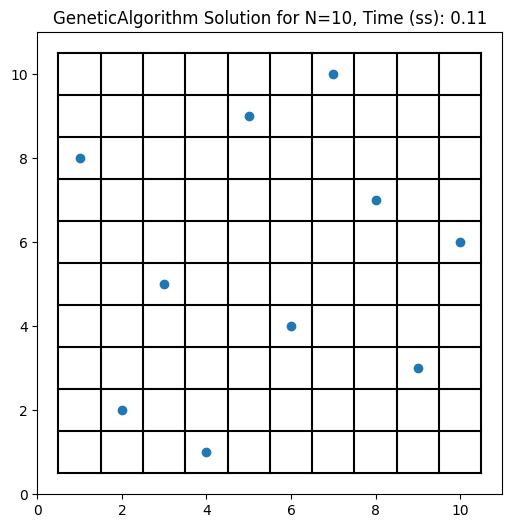

In [10]:
# Population size should be adapted to dimension N.
# for N=4 -> 20
# for N=5 -> 100
# for N=6 -> 500
# for N>=7 -> 1000
POPULATION_SIZE = 1000

# entering the input
while True:
    dimension = input("Enter board dimension (the desired number of queens): ")
    try:
        dimension = int(dimension)
        if dimension < 4:
            print("Error: Dimension should be an integer n>=4, try again!")
        else:
            break
    except ValueError:
        print("ValueError: Dimension must be an integer n>=4, try again!")

# we instantiate the GeneticChess class
chess = GeneticChess(dimension,POPULATION_SIZE)

# Solving N Queen problem with GA solver
print(f'\nSolving N={dimension} Queen problem with Genetic Algorithm Solver...')
start = time()
solution = chess.find_solution()
end = time()

# create the board for N dimension, and output the solution (if there is one)
if type(solution)==list:
    board = create_board(chess.size)
    set_board(board, solution, chess.size)
    print("\nSolution:")
    solution = [x+1 for x in solution]
    print(solution)
    duration = f'Time (ss): {round(end - start,2)}'
    print()
    print(duration)
    show_results(solution, duration, chess.size, 'GeneticAlgorithm')
else:
    print('No solution was found, please try again!')